In [1]:
%reload_ext autoreload
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
w_ = np.array([[1], [1]])

noise_scale = 10

n = 300




In [3]:
rho = 0.8
X = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], n)
Y = X.dot(w_).reshape((-1, 1)) + np.random.normal(scale=noise_scale, size=(n, 1))

# Classical Method

In [4]:
import statsmodels.api as sm

In [5]:

model = sm.OLS(Y, X)
results = model.fit()

In [6]:
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.462
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           0.000688
Time:                        09:45:52   Log-Likelihood:                -1120.2
No. Observations:                 300   AIC:                             2244.
Df Residuals:                     298   BIC:                             2252.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.3454      0.955      2.455      0.0

In [7]:
print results.cov_params()

print results.cov_params() * np.sqrt(n)

[[ 0.91246837 -0.79200562]
 [-0.79200562  0.99752898]]
[[ 15.80441569 -13.71793971]
 [-13.71793971  17.27770872]]


# Bootstrap

In [8]:
Kbs = 3000 # number of bootstrap subsamples

In [9]:
wb_bs = []

for kbs in xrange(Kbs):
    ind_bs = np.random.choice(n, n)
    X_ = X[ind_bs, :]
    Y_ = Y[ind_bs, :]
    
    model_ = sm.OLS(Y_, X_)
    results_ = model_.fit()
    
    wb_bs.append(results_.params.tolist())
    


In [10]:
wb_bs = np.array(wb_bs)

In [11]:
print np.mean(wb_bs, axis=0)

print np.cov(wb_bs.T)

[ 2.3638376  -0.39720414]
[[ 0.78159894 -0.67351738]
 [-0.67351738  0.87923577]]


<IPython.core.display.Javascript object>


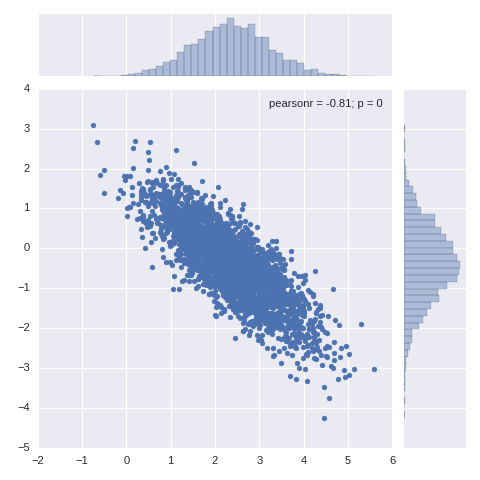

In [44]:
sns.jointplot(wb_bs[:,0], wb_bs[:,1], kind='scatter')

<IPython.core.display.Javascript object>


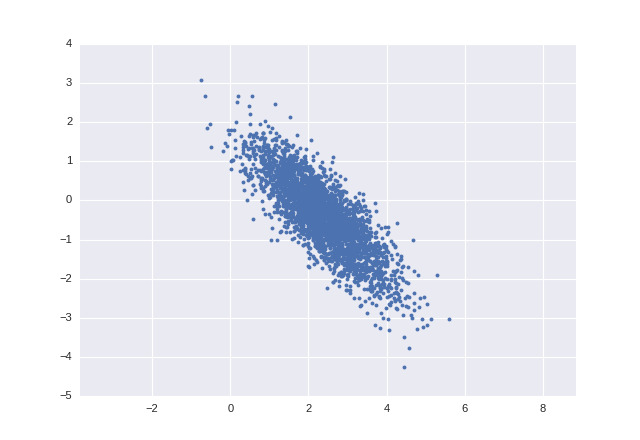

In [13]:
plt.figure()
plt.plot(wb_bs[:,0], wb_bs[:,1], '.')
plt.axes().set_aspect('equal', 'datalim')

# SGD

In [14]:
from __future__ import division

import tensorflow as tf

import random


def test_2d_tf(X_, Y_, n, size_batch, burn_in, sample_n, sample_intv, learning_rate, batch_replace):
    WBs = []
    
    X_ = X_.reshape((-1, 2))
    
    Y_ = Y_.reshape((-1, 1))
    
    X = tf.placeholder(tf.float64, [None, 2])
    
    Y = tf.placeholder(tf.float64, [None, 1])
    
    w = tf.Variable(initial_value=tf.zeros([2, 1], dtype=tf.float64), dtype=tf.float64)
    
    mse = tf.reduce_mean(tf.square(Y - tf.matmul(X, w)))
    
    opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(mse)
    
    init = tf.initialize_all_variables()
    
    n_iter = burn_in + (sample_n + 5) * sample_intv

    with tf.Session() as sess:
        sess.run(init)
        
        for i_ in xrange(n_iter):
            ind_batch = np.random.choice(range(n), size=size_batch, replace=batch_replace)
            
            Xb = X_[ind_batch, :].reshape((-1, 2))
            Yb = Y_[ind_batch, :].reshape((-1, 1))
            
            sess.run([opt], feed_dict={X: Xb, Y: Yb})
            
            if i_ > burn_in:
                if (i_ - burn_in) % sample_intv == 1:
                    wb = w.eval(session=sess).ravel().tolist()
                    WBs.append(wb)
    
    return np.array(WBs)


In [15]:

# size_batch = 30
# burn_in = 50000
# sample_n = 500

# learning_rate = 0.05

# sample_intv = 2000

# wb_sgd = test_2d_tf(X, Y, n, size_batch, burn_in, sample_n, sample_intv, learning_rate, batch_replace=True)


# print np.mean(wb_sgd, axis=0)

# print np.cov(wb_sgd.T)




# Multiple Pass SGD Bootstrap

In [16]:
from __future__ import division

import random

import math

def bs_multi_pass_sgd(X, Y, lr1, lr2, lr3, nBS):
    
    wb_all = []
    
    n, p = X.shape
    
    for _ in xrange(nBS):
        w = np.zeros((2, 1))
        
        for i in xrange(n):
            lr = lr1 / (lr2 + lr3 * math.sqrt(i))
            #lr = lr1 / (lr2 + lr3 * i)
            #lr = lr1
            
            ind_batch = random.randrange(n)
            
            Xb = X_[ind_batch, :].reshape((-1, 2))
            Yb = Y_[ind_batch, :].reshape((-1, 1))
            
            w = w - lr * (Xb.dot(w) - Yb) * Xb.T
        
        wb_all.append(w.ravel().tolist())
    
    return np.array(wb_all)

In [17]:
# lr1 = 0.01
# lr2 = 0.01
# lr3 = 0.2

# wb_bs_sgd = bs_multi_pass_sgd(X, Y, lr1, lr2, lr3, 1000)


In [18]:
# print np.mean(wb_bs_sgd, axis=0)

# print np.cov(wb_bs_sgd.T)

In [19]:
# plt.figure()
# plt.plot(wb_bs_sgd[:,0], wb_bs_sgd[:,1], '.')
# plt.axes().set_aspect('equal', 'datalim')

In [20]:
# sns.jointplot(wb_bs_sgd[:,0], wb_bs_sgd[:,1], kind='scatter',
#              xlim=[np.min(wb_bs_sgd[:]), np.max(wb_bs_sgd[:])], ylim=[np.min(wb_bs_sgd[:]), np.max(wb_bs_sgd[:])])

# SG LD MCMC

In [21]:
from __future__ import division

import math
import random

def test_2d_sg_ld_mcmc(X_, Y_, n, burn_in, sample_n, sample_intv, 
                       batch_size, 
                       learning_rate, lr1, lr2, lr3, 
                       batch_replace=True):
    Ws = []
    
    X_ = X_.reshape((-1, 2))
    
    Y_ = Y_.reshape((-1, 1))
    
    w = np.array([[0.0], [0.0]])
    
    n_iter = burn_in + (sample_n + 5) * sample_intv
    
    sqrt_2_lr = np.sqrt(2 * learning_rate)
    
    lr_sqrt_offset = 1
    
    n = X_.shape[0]
    H = (1 / n) * (X_.T.dot(X_))
    Hinv = np.linalg.inv(H)
    Hinv_sqrt = scipy.linalg.sqrtm(Hinv)
    
    batch_size_sqrt = math.sqrt(batch_size)
    
    for i_ in xrange(n_iter):
        ind_batch = np.random.choice(range(n), size=batch_size, replace=batch_replace)
        #ind_batch = random.randrange(n)
            
        Xb = X_[ind_batch, :].reshape((-1, 2))
        Yb = Y_[ind_batch, :].reshape((-1, 1))
        
#         w = w - (learning_rate) / (i_ + lr_sqrt_offset) * (Xb.dot(w) - Yb) * Xb.T \
#             + sqrt_2_lr / np.sqrt(i_ + lr_sqrt_offset) \
#             * np.random.multivariate_normal([0, 0], np.eye(2), 1).reshape((-1, 1))

        #lr = lr1 / (lr2 + lr3 * math.sqrt(i_))
        lr = learning_rate
        
        w = w - (lr / batch_size) * Hinv.dot(Xb.T.dot((Xb.dot(w) - Yb))) # Xb.T #* Hinv.dot(Xb.T) #\
            #+ 2 * sqrt_2_lr \
            #* np.random.multivariate_normal([0, 0], Hinv, 1).reshape((-1, 1))
            #* np.random.multivariate_normal([0, 0], np.eye(2), 1).reshape((-1, 1))
        
#         w = w - (learning_rate) * (Xb.dot(w) - Yb) * Xb.T \
#             + sqrt_2_lr \
#             * np.random.multivariate_normal([0, 0], np.eye(2), 1).reshape((-1, 1))
        
        
        if i_ > burn_in:
            if (i_ - burn_in) % sample_intv == 1:
                Ws.append(w.ravel().tolist())
                
        
    
    return np.array(Ws)
    

In [62]:


burn_in = 5000
sample_n = 500

learning_rate = .1 #1.0

sample_intv = 1000 #int(1.0 / (learning_rate ** 2))

lr1 = 0.1
lr2 = 0.1
lr3 = 0.01

batch_size = 64

wb_sgd = test_2d_sg_ld_mcmc(X, Y, n, burn_in, sample_n, sample_intv, 
                            batch_size, 
                            learning_rate, lr1, lr2, lr3,
                            batch_replace=True)







In [63]:
print np.mean(wb_sgd, axis=0)

print np.cov(wb_sgd.T)

print np.cov(wb_sgd.T) * 2 * batch_size / learning_rate / n



#print np.cov(wb_sgd.T) / (learning_rate / batch_size / 2)

[ 2.36073037 -0.39475417]
[[ 0.20707935 -0.17707401]
 [-0.17707401  0.22171709]]
[[ 0.88353854 -0.75551578]
 [-0.75551578  0.94599291]]


<IPython.core.display.Javascript object>


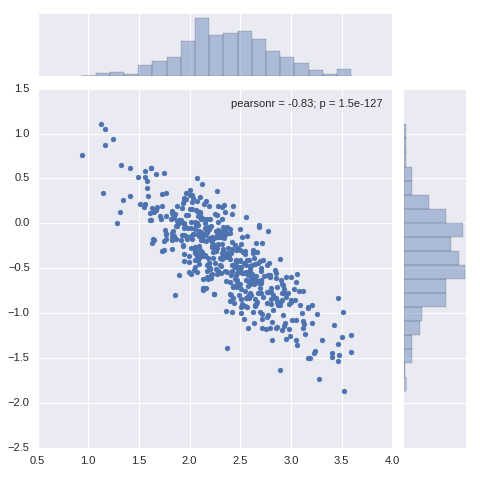

In [64]:
# sns.jointplot(wb_sgd[:,0], wb_sgd[:,1], kind='scatter',
#              xlim=[np.min(wb_sgd[:]), np.max(wb_sgd[:])], ylim=[np.min(wb_sgd[:]), np.max(wb_sgd[:])])

sns.jointplot(wb_sgd[:,0], wb_sgd[:,1], kind='scatter')

<IPython.core.display.Javascript object>


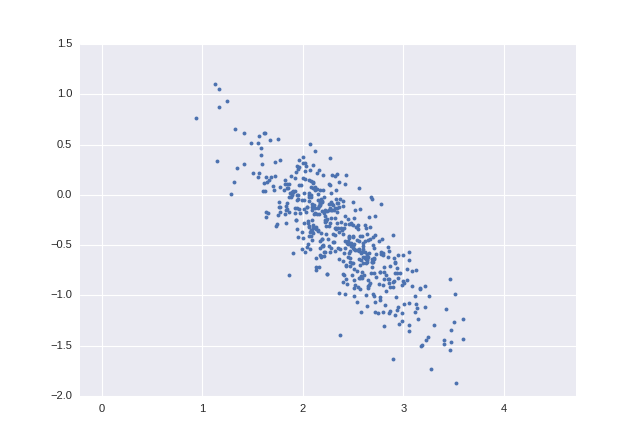

In [65]:
plt.figure()
plt.plot(wb_sgd[:,0], wb_sgd[:,1], '.')
plt.axes().set_aspect('equal', 'datalim')